<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [1]:
!pip install pyswmm
!pip install swmmio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 3.1 MB/s 
     |████████████████████████████████| 458 kB 44.2 MB/s 
     |████████████████████████████████| 131 kB 15.8 MB/s 
  Created wheel for julian: filename=julian-0.14-py3-none-any.whl size=2633 sha256=a3b300ccafc25c6d9e06cb55884287f4a30b64a349c7b97b51c4d1f73a5bda21
  Stored in directory: /root/.cache/pip/wheels/bb/58/2a/4109ff5870c163b26a499fb8b828ede50e96264571a4f082d3
Successfully built julian
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 3.7 MB/s 
     |████████████████████████████████| 215 kB 15.0 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-py3-none-any.whl size=32667 sha256=448f14d1c3e2a596ce9fe3c1fc07305dca9be289f8a88c1bb1fcdde54485eb55
  Stored in directory: /root/.cache/pip/wheels/a0/c5/f3/548a073ac6a83d5b23d9b39cdd243

# Import 

In [2]:
import os
import swmmio
import tempfile
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from swmmio.utils.dataframes import dataframe_from_inp
from swmmio.utils.text import get_inp_sections_details
from swmmio.utils.modify_model import replace_inp_section
from swmmio.version_control.utils import write_inp_section
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# Prepare model for managing

In [4]:
#initialize a baseline model object
baseline = swmmio.Model('example.inp')
#create copy the base model 
newfilepath = os.path.join(baseline.inp.name + "_" + 'copy' + '.inp')
# save new file
baseline.inp.save(newfilepath)

# Explore model data

In [10]:
model = swmmio.Model('example_copy.inp')
# df_subcatchments = dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
df_subcatchments = model.inp.subcatchments

In [11]:
df_subcatchments.head()

,Raingage,Outlet,...,PercSlope,CurbLength
Name,,,,,
S1,1,J1,...,10,0


In [12]:
df_subcatchments.loc["S1", "PercImperv"] = 15
model.inp.subcatchments = df_subcatchments

In [13]:
df_subcatchments[:2]

,Raingage,Outlet,...,PercSlope,CurbLength
Name,,,,,
S1,1,J1,...,10,0


In [14]:
swmmio.utils.modify_model.replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', df_subcatchments)

In [19]:
model = swmmio.Model('example_copy.inp')
subareas = model.inp.subareas
subareas.loc["S1", "N-Imperv"] = 0.1
model.inp.subareas = subareas
replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

In [20]:
m = swmmio.Model('example_copy.inp')
sub = m.inp.subareas
sub.head()

,N-Imperv,N-Perv,...,PctZero,RouteTo
Name,,,,,
S1,0.1,1,...,25,OUTLET


In [ ]:
''' PySWMM doesn't allow to set percent imprevious parameter.
It's important to check impact this feature on runoff.
This is the reason to overide imprevious value in dataftame 
and overwrite model with new data.
'''
def overwrite_percent_imprevious(value: float, subcatchment_id: str, file_path: str = 'example_copy.inp') -> None:
    model = swmmio.Model(file_path)

    #create a dataframe of the model's subcatchments
    subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')

    # subcatchments = model.subcatchments.dataframe
    subcatchments.loc[subcatchment_id, "PercImperv"] = value

    #overwrite file with new data
    swmmio.utils.modify_model.replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

# overwrite_percent_imprevious(value=50, subcatchment_id='S1', file_path='example_copy.inp')


In [ ]:
model = swmmio.Model('example_copy.inp')
sub = model.subcatchments.dataframe
sub.head()

,Raingage,Outlet,...,RouteTo,coords
Name,,,,,
S1,1,J1,...,OUTLET,"[(777172.413, 592589.245), (777181.812, 592589.633), (777181.932, 592580.323), (777172.652, 592580.174), (777172.413, 592589.364), (777172.413, 592589.245)]"


In [ ]:
def calculate(subcatchment_id=None, conduit_id=None, file_path='example_copy.inp'):
    with Simulation(file_path) as sim:
        catchment = Subcatchments(sim)[subcatchment_id]
        conduit = Links(sim)[conduit_id]
        for _ in sim: pass
        return catchment.statistics, conduit.conduit_statistics
        

def simulate_catchment_features(subcatchment_id=None, conduit_id=None, min=1, max=100, step=10, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    iterator = [min]
    counter = min
    while counter < max:
        counter += step
        iterator.append(counter)
    slope, percent_impervious, area = [], [], []
    for a in range(1, 16, 1):
        for s in iterator:
            for i in iterator:
                slope.append(s)
                percent_impervious.append(i)
                area.append(a)
                model = swmmio.Model(file_path)
                subcatchments = swmmio.utils.dataframes.dataframe_from_inp(file_path, '[SUBCATCHMENTS]')
                subcatchments.loc[subcatchment_id, "PercSlope"] = s/100
                subcatchments.loc[subcatchment_id, "PercImperv"] = i
                subcatchments.loc[subcatchment_id, "Area"] = a
                replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                catchment_stats = calculate(subcatchment_id=subcatchment_id,  conduit_id=conduit_id, file_path=model.inp.path)
                conduit_stats = conduit
                for key in catchment_data:
                    catchment_data[key].append(catchment_stats[key])
                counter += step
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    catchment_data["area"] = area
    return pd.DataFrame(data=catchment_data)


In [ ]:
analyse = simulate_catchment_features(subcatchment_id='S1', min=1, max=100, step=10, file_path='example_copy.inp')

example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to ini

In [ ]:
analyse.head()

,runoff,peak_runoff_rate,...,slope,percent_impervious
0,4147.421663,0.708872,...,1,1
1,4309.578675,0.820048,...,1,11
2,4453.766020,0.926754,...,1,21
3,4580.965259,1.027848,...,1,31
4,4690.803627,1.121749,...,1,41


# Simulate percent imprevious feature 

## Prepare method for simulation

In [73]:
# def simulate_percent_imprevious(subcatchment_id=None, min=0.1, max=100, step=10, file_path='example_copy.inp'):
#     catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
#     model = swmmio.Model(file_path)
#     subcatchments = model.inp.subcatchments
#     subareas = model.inp.subareas
#     area = subcatchments.loc[subcatchment_id, "Area"]
#     width = subcatchments.loc[subcatchment_id, "Width"]
#     percent_slope = subcatchments.loc[subcatchment_id, "PercSlope"]
#     curb_length = subcatchments.loc[subcatchment_id, "CurbLength"]
#     n_imperv = subareas.loc[subcatchment_id, 'N-Imperv']
#     n_perv = subareas.loc[subcatchment_id, "N-Perv"]
#     destore_iperv = subareas.loc[subcatchment_id, "S-Imperv"]
#     destore_perv = subareas.loc[subcatchment_id, "S-Perv"]
#     zero_imperv = subareas.loc[subcatchment_id, "PctZero"]
#     percent_impervious = []
#     counter = min
#     while counter < max:
#         subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
#         subcatchments.loc[subcatchment_id, "PercImperv"] = counter
#         percent_impervious.append(counter)
#         replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

#         with Simulation(model.inp.path) as sim:
#             catchment = Subcatchments(sim)[subcatchment_id]
#             for _ in sim: pass
#             catchment_stats = catchment.statistics          
#             for key in catchment_data:
#                 catchment_data[key].append(catchment_stats[key])
#         counter += step
#     catchment_data["percent_impervious"] = percent_impervious
#     dataframe = pd.DataFrame(data=catchment_data)
#     dataframe[["area", "width", "percent_slope", "curb_length", "n_imperv", "n_perv", "destore_iperv", "destore_perv", "zero_imperv"]] = [area, width, percent_slope, curb_length, n_imperv, n_perv, destore_iperv, destore_perv, zero_imperv]
#     return dataframe

def simulate_percent_imprevious(subcatchment_id=None, min=0.1, max=100, step=10, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    percent_impervious = []
    counter = min
    while counter < max:
        subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
        subcatchments.loc[subcatchment_id, "PercImperv"] = counter
        percent_impervious.append(counter)
        replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
        counter += step
    catchment_data["percent_impervious"] = percent_impervious
    return pd.DataFrame(data=catchment_data)

## Get imprevious data

In [74]:
df_percent_imprevious =  simulate_percent_imprevious(subcatchment_id='S1', min=1, max=100, step=1, file_path='example_copy.inp')

example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to ini

In [75]:
df_percent_imprevious.head()

,runoff,peak_runoff_rate,infiltration,evaporation,percent_impervious
0,2613.411115,0.163309,549.871553,0.0,1
1,2646.127865,0.164322,543.859269,0.0,2
2,2678.563223,0.165327,537.850565,0.0,3
3,2710.740082,0.166322,531.845502,0.0,4
4,2742.671309,0.167308,525.844147,0.0,5


In [76]:
df_percent_imprevious.shape

(99, 5)

## Subcatchments data output


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


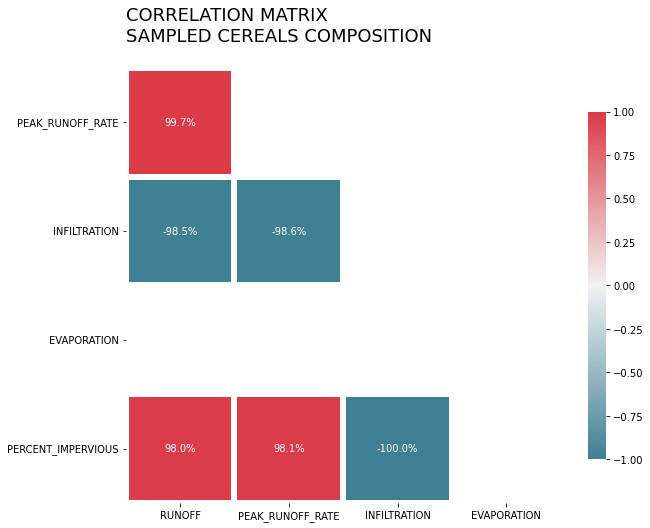

In [77]:
# read dataset
df = df_percent_imprevious.copy()
# get correlations
df_corr = df.corr()
# irrelevant fields
# fields = ['time_full_flow', 'time_normal_flow', 'peak_velocity', 'peak_flow_date', 'peak_flow', 'peak_depth', 'flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream', 'evaporation']
# # drop rows
# df_corr.drop(fields, inplace=True)
# # drop cols
# df_corr.drop(fields, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".1%", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX\nSAMPLED CEREALS COMPOSITION\n'
plt.title(title, loc='left', fontsize=18)
plt.show()

### Dependence of runoff on subcatchment imprevious.


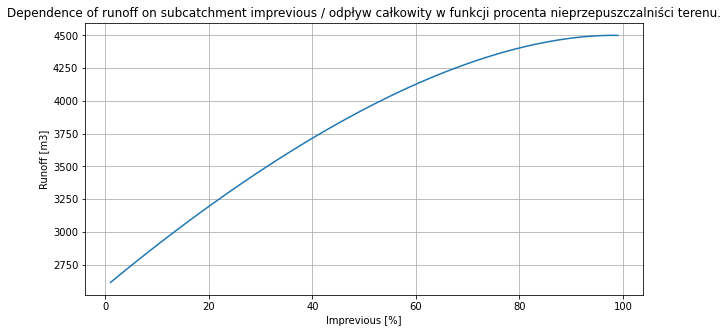

In [38]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['runoff'])
plt.title('Dependence of runoff on subcatchment imprevious / odpływ całkowity w funkcji procenta nieprzepuszczalniści terenu.')
plt.xlabel('Imprevious [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment imprevious.


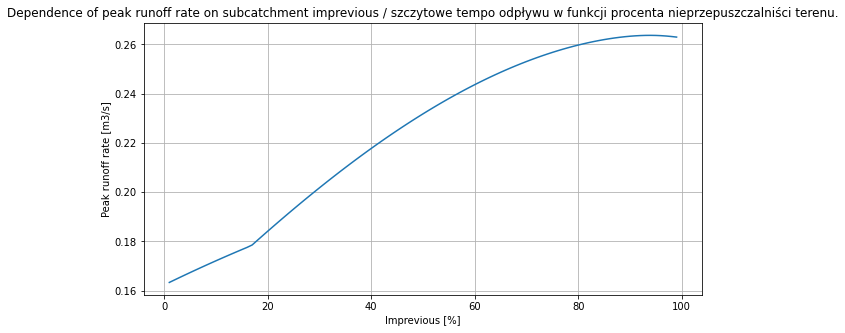

In [39]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment imprevious / szczytowe tempo odpływu w funkcji procenta nieprzepuszczalniści terenu.')
plt.xlabel('Imprevious [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious


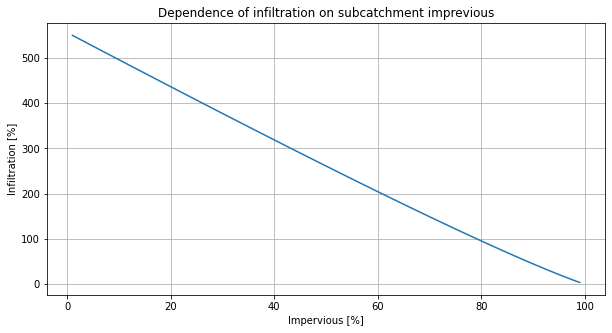

In [40]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['infiltration'])
plt.title('Dependence of infiltration on subcatchment imprevious')
plt.xlabel('Impervious [%]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

# Simulate percent slope feature

## Prepare methoed for analyse slope

In [41]:
def simulate_catchments_slope(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    slope = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.slope = counter/100
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            conduit_stats = conduit.conduit_statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            for key in conduit_data:
                conduit_data[key].append(conduit_stats[key])
            slope.append(counter)
        counter += step
    catchment_data["slope"] = slope
    return pd.DataFrame(data={**catchment_data, **conduit_data})

## Get slope data

In [42]:
df_slope = simulate_catchments_slope("S1", "C3")

In [43]:
df_slope.head()

,runoff,peak_runoff_rate,...,time_full_upstream,time_normal_flow
0,2434.556064,0.133824,...,0.0,0.0
1,2715.559117,0.150814,...,0.0,0.0
2,2883.670145,0.161459,...,0.0,0.0
3,3002.172768,0.169165,...,0.0,0.0
4,3092.726491,0.175159,...,0.0,0.0


## Subcatchment data output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


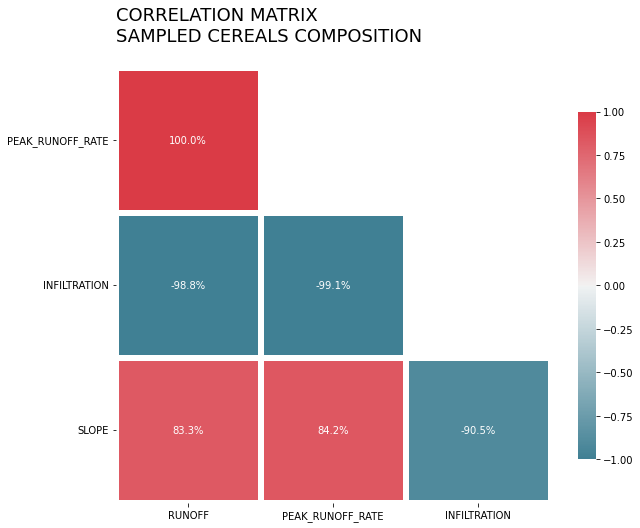

In [44]:
# read dataset
df = df_slope.copy()
# get correlations
df_corr = df.corr()
# irrelevant fields
fields = ['time_full_flow', 'time_normal_flow', 'peak_velocity', 'peak_flow_date', 'peak_flow', 'peak_depth', 'flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream', 'evaporation']
# drop rows
df_corr.drop(fields, inplace=True)
# drop cols
df_corr.drop(fields, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".1%", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX\nSAMPLED CEREALS COMPOSITION\n'
plt.title(title, loc='left', fontsize=18)
plt.show()

### Dependence of runoff on subcatchment slope.

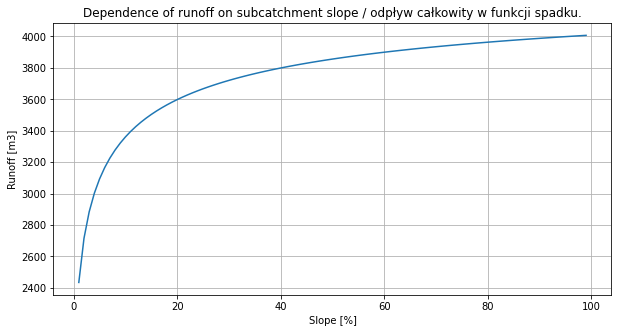

In [45]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['runoff'])
plt.title('Dependence of runoff on subcatchment slope / odpływ całkowity w funkcji spadku.')
plt.xlabel('Slope [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment slope

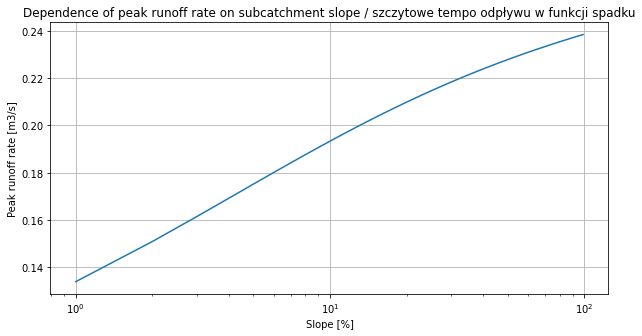

In [46]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment slope / szczytowe tempo odpływu w funkcji spadku')
plt.xlabel('Slope [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment slope

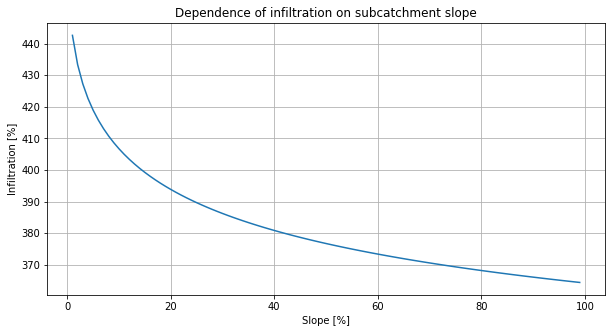

In [47]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['infiltration'])
plt.title('Dependence of infiltration on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

### Dependence of maximal flow on subcatchment slope.

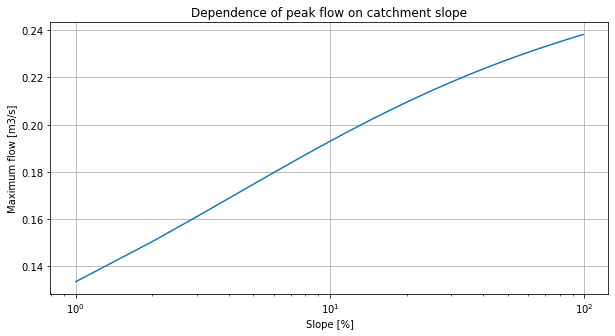

In [48]:
# maksymaly przepływ [m3/s] w funkcji spadku terenu zlewni.
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_flow'])
plt.title('Dependence of peak flow on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

### Dependence of maximal velocity on subcatchment slope


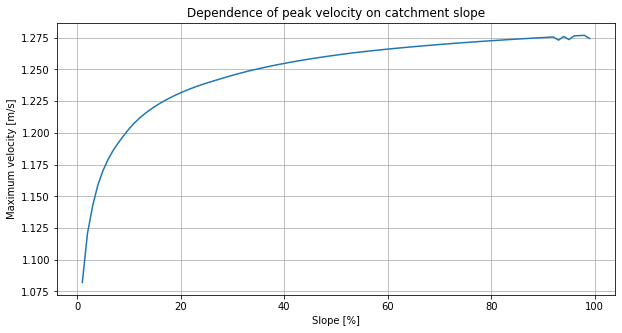

In [49]:
# peak_velocity - maksymalna prędkość przepływu [m/s]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_velocity'])
plt.title('Dependence of peak velocity on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()

### Dependence of maximal pipe filling on subcatchment slope.

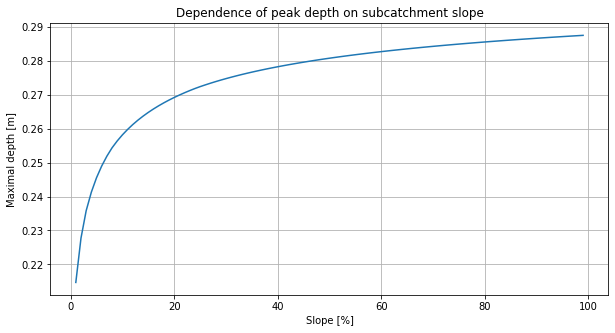

In [50]:
# maksymalna wysokość napełnienia kanału  w sunkcji spadku terenu zlewni [m]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_depth'])
plt.title('Dependence of peak depth on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximal depth [m]')
plt.grid(True)
plt.show()

# Simulate N-Imperv (Mannings N for imprevious area)

### Description for N-Imperv value
Source: McCuen, R. et al. (1996), Hydrology, FHWA-SA-96-067, Federal Highway Administration, Washington, DC.


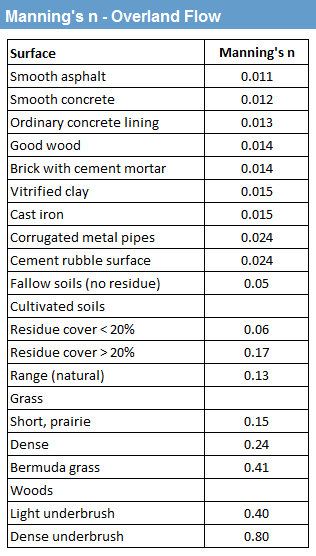


## Prepare method for simulation

In [81]:
def simulate_n_imprev(subcatchment_id=None, file_path='example_copy.inp'):
    minings_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    percent_impervious = []
    model = swmmio.Model(file_path)
    for n in minings_n:
        subareas = model.inp.subareas
        subareas.loc["S1", "N-Imperv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["N-Imperv"] = minings_n
    return df

## Get N-Impervious data

In [82]:
df_n_impervious = simulate_n_imprev("S1")

example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to ini

In [84]:
df_n_impervious.shape
df_n_impervious.head()

,runoff,peak_runoff_rate,infiltration,evaporation,N-Imperv
0,4771.190451,0.277690,3.91886,0.0,0.011
1,4766.628114,0.277675,3.91886,0.0,0.012
2,4762.199117,0.277655,3.91886,0.0,0.013
3,4757.887495,0.277629,3.91886,0.0,0.014
4,4753.680101,0.277598,3.91886,0.0,0.015


## Subcatchment data output

### Dependence of runoff on subcatchment imprevious.

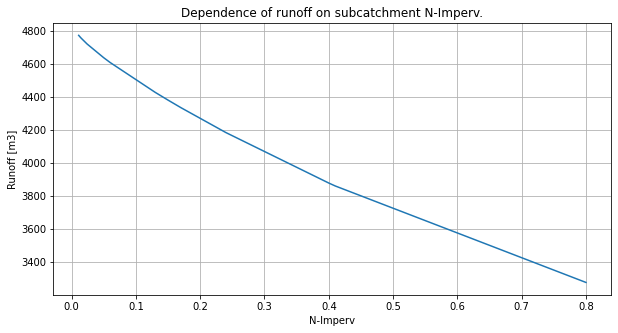

In [87]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_impervious['N-Imperv'], df_n_impervious['runoff'])
plt.title('Dependence of runoff on subcatchment N-Imperv.')
plt.xlabel('N-Imperv')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment imprevious.

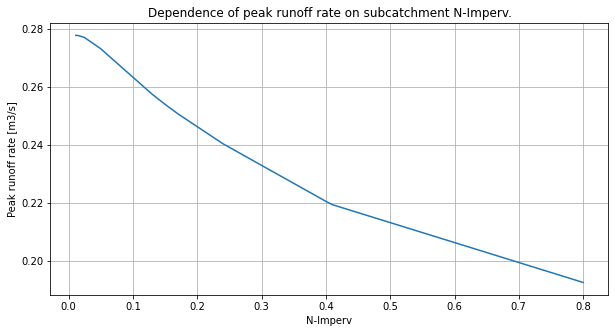

In [86]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_impervious['N-Imperv'], df_n_impervious['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment N-Imperv.')
plt.xlabel('N-Imperv')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious

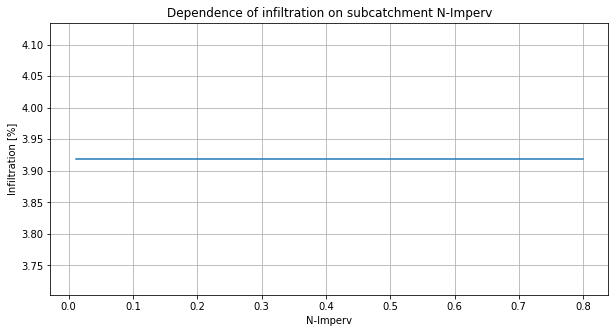

In [88]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_impervious['N-Imperv'], df_n_impervious['infiltration'])
plt.title('Dependence of infiltration on subcatchment N-Imperv')
plt.xlabel('N-Imperv')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

# Simulate N-Perv (Mannings N for revious area)

## Description
Source: McCuen, R. et al. (1996), Hydrology, FHWA-SA-96-067, Federal Highway Administration, Washington, DC.



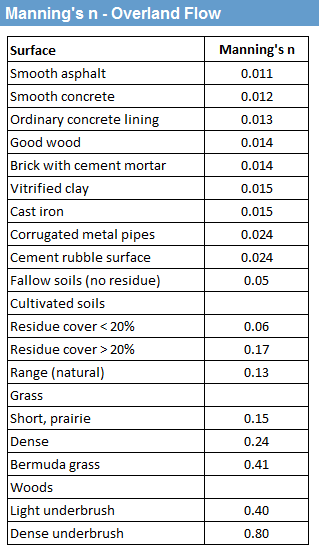

## Prepare method for simulation

In [106]:
def simulate_n_prev(subcatchment_id=None, file_path='example_copy.inp'):
    minings_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    percent_impervious = []
    model = swmmio.Model(file_path)
    for n in minings_n:
        subareas = model.inp.subareas
        subareas.loc["S1", "N-Perv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["N-Perv"] = minings_n
    return df

## Get N-Previous data

In [107]:
df_n_perv = simulate_n_prev("S1")

example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to ini

In [108]:
df_n_perv.shape
df_n_perv.head()

,runoff,peak_runoff_rate,infiltration,evaporation,N-Perv
0,3276.131537,0.192734,3.676376,0.0,0.011
1,3276.130834,0.192734,3.677399,0.0,0.012
2,3276.127846,0.192734,3.678387,0.0,0.013
3,3276.125007,0.192734,3.679344,0.0,0.014
4,3276.123106,0.192734,3.680274,0.0,0.015


## Subcatchments data output

### Dependence of runoff on subcatchment N-Perv.


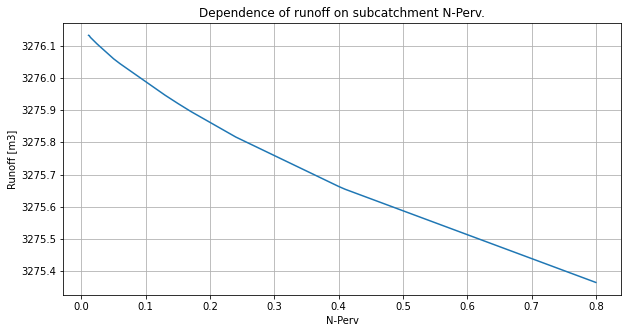

In [104]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_perv['N-Perv'], df_n_perv['runoff'])
plt.title('Dependence of runoff on subcatchment N-Perv.')
plt.xlabel('N-Perv')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment N-Perv.

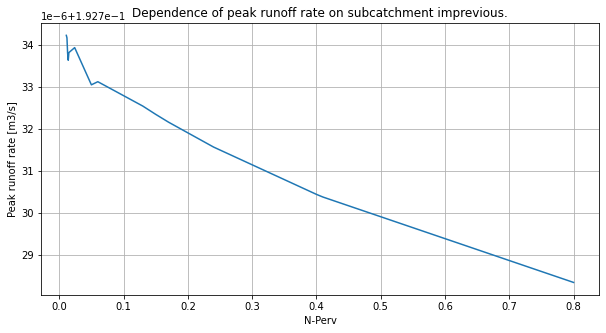

In [109]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_perv['N-Perv'], df_n_perv['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment imprevious.')
plt.xlabel('N-Perv')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious

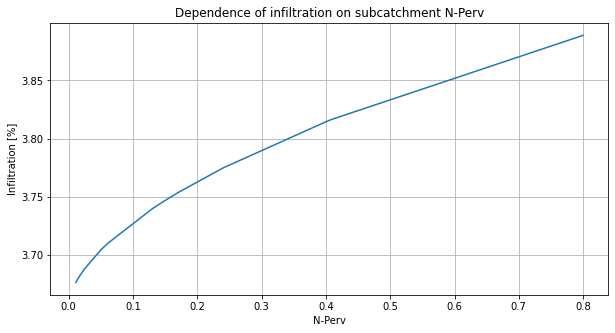

In [110]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_perv['N-Perv'], df_n_perv['infiltration'])
plt.title('Dependence of infiltration on subcatchment N-Perv')
plt.xlabel('N-Perv')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

# Simulate area feature

## Prepare method for simulation

In [ ]:
def simulate_catchments_area(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    area = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.area = counter
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            conduit_stats = conduit.conduit_statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            for key in conduit_data:
                conduit_data[key].append(conduit_stats[key])
            area.append(counter)
        counter += step
    catchment_data["area"] = area
    return pd.DataFrame(data={**catchment_data, **conduit_data})

## Get area data

In [ ]:
df_area = simulate_catchments_area("S1", "C3")

In [ ]:
df_area.head()

,runoff,peak_runoff_rate,...,time_full_upstream,time_normal_flow
0,996.596274,0.276626,...,0.0,4.242144
1,1989.570566,0.553289,...,0.0,3.551445
2,2978.552360,0.829890,...,0.0,2.928762
3,3965.384309,1.106532,...,0.0,2.489477
4,4950.427329,1.383118,...,0.0,2.533971


## Subcatchments data output

### Dependence of runoff on subcatchment area.

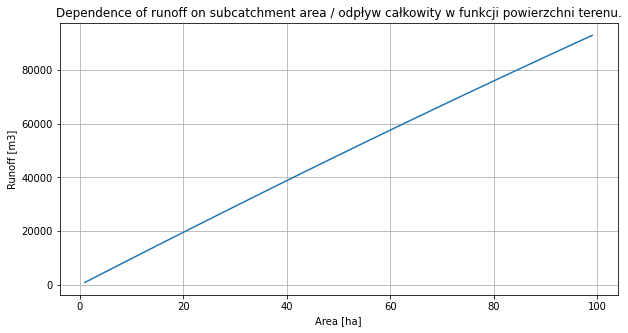

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['runoff'])
plt.title('Dependence of runoff on subcatchment area / odpływ całkowity w funkcji powierzchni terenu.')
plt.xlabel('Area [ha]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment area.

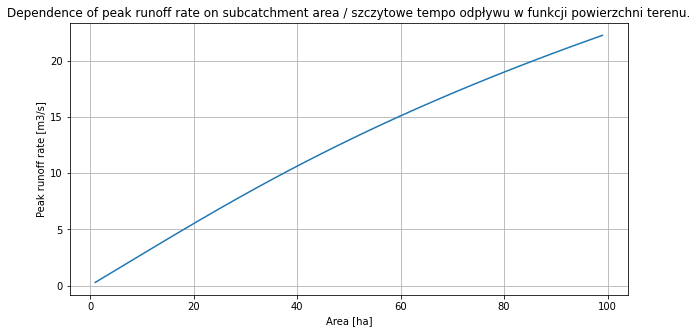

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment area / szczytowe tempo odpływu w funkcji powierzchni terenu.')
plt.xlabel('Area [ha]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment area.

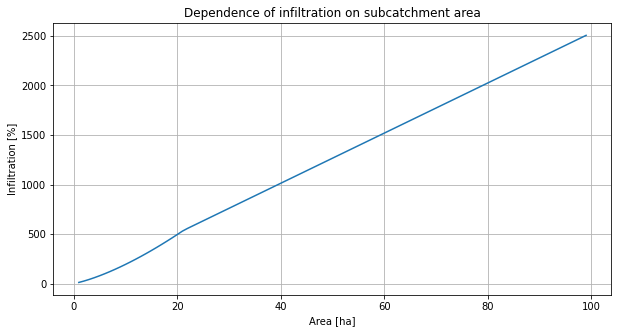

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['infiltration'])
plt.title('Dependence of infiltration on subcatchment area')
plt.xlabel('Area [ha]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

In [ ]:
def simulate_catchment(subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    iterator = [min_slope]
    counter = min_slope
    while counter < max_slope:
        counter += step
        iterator.append(counter)
    slope, percent_impervious, areas, runoff_total_loading = [], [], [], []
    conc_ponded, buildup, evaporation_loss = [], [], []
    for a in range(1, 30, 1):
        for s in iterator:
            for i in iterator:
                with Simulation(file_path) as sim:
                    catchment = Subcatchments(sim)[subcatchment_id]
                    catchment.slope = s
                    catchment.percent_impervious = i
                    catchment.area = a
                    runoff_total_loading.append(catchment.runoff_total_loading)
                    conc_ponded.append(catchment.conc_ponded)
                    buildup.append(catchment.buildup)
                    evaporation_loss.append(catchment.evaporation_loss)
                    slope.append(s)
                    percent_impervious.append(catchment.percent_impervious) 
                    print(catchment.percent_impervious)
                    areas.append(a)
                    for _ in sim:
                        pass
                    catchment_stats = catchment.statistics
                    for key in catchment_data:
                        catchment_data[key].append(catchment_stats[key])
        print(f"loop: {a}")
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    catchment_data["area"] = areas
    return pd.DataFrame(data=catchment_data)

# Simulate all feature

## Prepare method for simulation

In [ ]:
def calculate(subcatchment_id=None, conduit_id=None, file_path='example_copy.inp'):
    with Simulation(file_path) as sim:
        catchment = Subcatchments(sim)[subcatchment_id]
        conduit = Links(sim)[conduit_id]
        for _ in sim: pass
        return catchment.statistics, conduit.conduit_statistics
        

def simulate_catchment_features(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    # conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    iterator = [min]
    counter = min
    while counter < max:
        counter += step
        iterator.append(counter)
    slope, percent_impervious, area = [], [], []
    for a in range(1, 5, 1):
        for s in iterator:
            for i in iterator:
                slope.append(s)
                percent_impervious.append(i)
                area.append(a)
                model = swmmio.Model(file_path)
                subcatchments = swmmio.utils.dataframes.dataframe_from_inp(file_path, '[SUBCATCHMENTS]')
                # subcatchments.loc[subcatchment_id, "PercSlope"] = s/100
                subcatchments.loc[subcatchment_id, "PercImperv"] = i
                # subcatchments.loc[subcatchment_id, "Area"] = a
                replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                
                with Simulation(model.inp.path) as sim:
                    catchment = Subcatchments(sim)[subcatchment_id]
                    # conduit = Links(sim)[conduit_id]
                    catchment.slope = s/100
                    catchment.area = a
                    for _ in sim: pass
                    catchment_stats = catchment.statistics
                    # conduit_stats = conduit.conduit_statistics
                
                # catchment_stats, conduit_stats = calculate(subcatchment_id=subcatchment_id,  conduit_id=conduit_id, file_path=model.inp.path)
                for key in catchment_data:
                    catchment_data[key].append(catchment_stats[key])
                # for key in conduit_data:
                #     conduit_data[key].append(conduit_stats[key])
                counter += step
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    catchment_data["area"] = area
    return pd.DataFrame(data={**catchment_data})
    # return pd.DataFrame(data={**catchment_data, **conduit_data})


## Get features data

In [ ]:
analyse = simulate_catchment_features("S1", "C3", step=10)

example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to ini

In [ ]:
analyse.head()

,runoff,peak_runoff_rate,...,percent_impervious,area
0,987.466919,0.276256,...,1,1
1,989.585477,0.276416,...,11,1
2,991.714520,0.276571,...,21,1
3,993.929070,0.276732,...,31,1
4,996.139886,0.276890,...,41,1


In [ ]:
# analyse.drop(columns=['flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream', 'evaporation'], axis=1, inplace=True)
# analyse.drop(columns=['time_full_flow'], axis=1, inplace=True)
analyse.head()

KeyError: ignored

In [ ]:
analyse.shape

(484, 7)

## Subcatchments data output

### Show feature correlations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


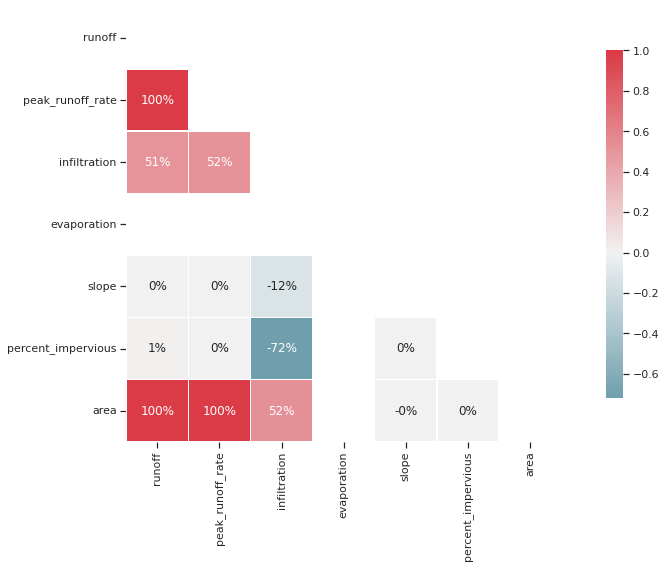

In [ ]:
df_corr = analyse.copy()
corr = df_corr.corr()

sns.set(style="ticks")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(16, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt=".0%",
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


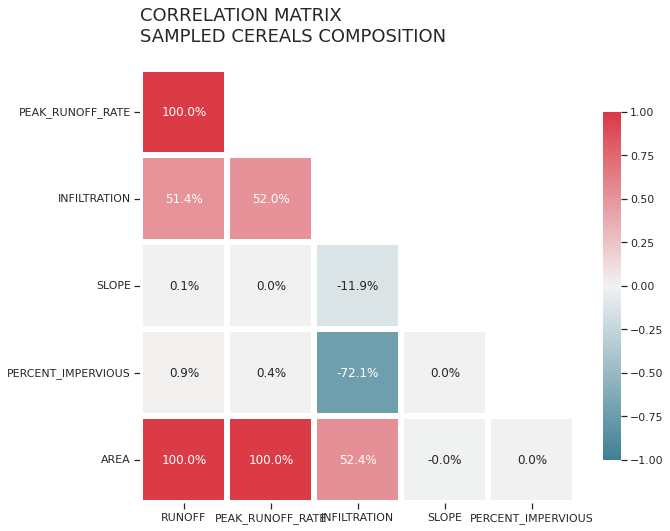

In [ ]:
# read dataset
df = analyse.copy()
# get correlations
df_corr = df.corr()
# irrelevant fields
fields = ['evaporation']
# drop rows
df_corr.drop(fields, inplace=True)
# drop cols
df_corr.drop(fields, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".1%", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX\nSAMPLED CEREALS COMPOSITION\n'
plt.title(title, loc='left', fontsize=18)
plt.show()

```
Name
 Nazwa zlewni przypisana przez użytkownika.
 
X-Coordinate
Pozioma lokalizacja centroida zlewni na mapie obszaru opracowania. Jeśli pozostanie pusta zlewnia nie będzie wyświetlana na mapie.
 
Y-Coordinate
 Pionowa lokalizacja centroida zlewni na mapie obszaru badań. Jeśli pozostanie pusta zlewnia nie pojawi się na mapie.
 
Description
 Kliknąć przycisk wielokropka (lub nacisnąć Enter) aby edytować opcjonalny opis zlewni.
 
Tag
 Opcjonalna etykieta używana do kategoryzacji lub klasyfikacji zlewni.

Rain Gage
 Nazwa deszczowni powiązanej z daną zlewnią cząstkową.
 
Outlet
 Nazwa węzła lub zlewni która odbiera odpływ z zlewni.
 
Area
 Powierzchnia zlewni cząstkowej w tym wszelkie kontrole LID (akry lub hektary)

Width
 Charakterystyczna szerokość ścieżki przepływu lądowego dla spływu powierzchniowego (stopy lub metry).

(More...)
 
% Slope
 Średnie procentowe nachylenie zlewni.
 
% Imperv
 Procent powierzchni terenu (bez uwzględnienia jakichkolwiek LID) która jest nieprzepuszczalna.

N-Imperv
  N Manninga dla przepływu śródlądowego przez nieprzepuszczalną część zlewni cząstkowej.
 
N-Perv
 Współczynnik Manninga n dla przepływu lądowego przez nieprzepuszczalną część zlewni cząstkowej.
 
Dstore-Imperv
 Głębokość składowania wgłębnego na nieprzepuszczalnej części zlewni cząstkowej (cale lub milimetry). (Typowe wartości).
 
Dstore-Perv
 Depth of depression storage on the pervious portion of the subcatchment (inches or millimeters) (Typical Values).
 
% Zero-Imperv
 Procent obszaru nieprzepuszczalnego bez magazynowania depresji.

Subarea Routing
 Wybór wewnętrznej trasy spływu pomiędzy obszarami przepuszczalnymi i nieprzepuszczalnymi:

IMPERV: spływ z powierzchni przepuszczalnej dopływa do powierzchni nieprzepuszczalnej

PERV:      spływ z powierzchni nieprzepuszczalnej dopływa do powierzchni przepuszczalnej

OUTLET:  spływ z obu obszarów spływa bezpośrednio do wylotu
 
Percent Routed
 Procentowy udział odpływu prowadzonego pomiędzy podobszarami.
 
Infiltration
 Kliknąć przycisk wielokropka (lub nacisnąć Enter) aby edytować parametry infiltracji dla zlewni cząstkowej.
 
LID Controls

 
 Kliknąć przycisk wielokropka (lub nacisnąć Enter) aby edytować wykorzystanie kontroli rozwoju o niskim wpływie w zlewni.
 
Groundwater
 Kliknij przycisk wielokropka (lub naciśnij Enter) aby edytować parametry przepływu wód gruntowych dla zlewni cząstkowej.
 
Snow Pack
 Nazwa zestawu parametrów pakietu śniegu (jeśli istnieje) przypisanego do zlewni cząstkowej.
 
Land Uses
 Kliknij przycisk wielokropka (lub naciśnij Enter) aby przypisać użytkowanie terenu do zlewni cząstkowej. Potrzebne tylko w przypadku modelowania gromadzenia się zanieczyszczeń/odpływu wód gruntowych.
 
Initial Buildup
 Kliknij przycisk wielokropka (lub naciśnij Enter) aby określić początkowe ilości zanieczyszczeń gromadzących się w zlewni cząstkowej.
 
Curb Length
 Całkowita długość krawężników w zlewni cząstkowej (dowolne jednostki długości). Używane tylko wtedy gdy nagromadzenie zanieczyszczeń jest normalizowane do długości krawężnika.
 
N-Perv Pattern
  Nazwa opcjonalnego miesięcznego wzorca czasowego zastosowanego do współczynnika Manninga n (N-Perv). Pozostaw puste jeśli nie ma zastosowania.
 
Dstore Pattern
  Nazwa opcjonalnej miesięcznej korekty wzorca czasu stosowanej do obu wartości magazynowania depresji (Dstore). Pozostawić puste jeśli nie dotyczy.
 
Infil. Pattern
 Nazwa opcjonalnej miesięcznej korekty Time Pattern zastosowanej do przewodności hydraulicznej powierzchni przepuszczalnej. Pozostawić puste jeśli nie dotyczy.
```

```
Name
 User-assigned subcatchment name.
 
X-Coordinate
 Horizontal location of the subcatchment's centroid on the Study Area Map. If left blank then the subcatchment will not appear on the map.
 
Y-Coordinate
 Vertical location of the subcatchment's centroid on the Study Area Map. If left blank then the subcatchment will not appear on the map.
 
Description
 Click the ellipsis button (or press Enter) to edit an optional description of the subcatchment.
 
Tag
 Optional label used to categorize or classify the subcatchment.
 
Rain Gage
 Name of the rain gage associated with the subcatchment.
 
Outlet
 Name of the node or subcatchment that recieves the subcatchment's runoff.
 
Area
 Area of the subcatchment including any LID controls (acres or hectares).
 
Width
 Characteristic width of the overland flow path for sheet flow runoff (feet or meters).

(More...)
 
% Slope
 Average percent slope of the subcatchment.
 
% Imperv
 Percent of the land area (not including any LIDs) which is impervious.
 
N-Imperv
 Manning's n for overland flow over the impervious portion of the subcatchment.

(Typical Values).
 
N-Perv
 Manning's n for overland flow over the pervious portion of the subcatchment.

(Typical Values).
 
Dstore-Imperv
 Depth of depression storage on the impervious portion of the subcatchment (inches or millimeters). (Typical Values).
 
Dstore-Perv
 Depth of depression storage on the pervious portion of the subcatchment (inches or millimeters) (Typical Values).
 
% Zero-Imperv
 Percent of the impervious area with no depression storage.
 
Subarea Routing
 Choice of internal routing of runoff between pervious and impervious areas:

IMPERV: runoff from pervious area flows to impervious area

PERV:      runoff from impervious flows to pervious area

OUTLET:  runoff from both areas flows directly to outlet
 
Percent Routed
 Percent of runoff routed between subareas.
 
Infiltration
 Click the ellipsis button (or press Enter) to edit infiltration parameters for the subcatchment.
 
LID Controls

 
 Click the ellipsis button (or press Enter) to edit the use of low impact development controls in the subcatchment.
 
Groundwater
 Click the ellipsis button (or press Enter) to edit groundwater flow parameters for the subcatchment.
 
Snow Pack
 Name of snow pack parameter set (if any) assigned to the subcatchment.
 
Land Uses
 Click the ellipsis button (or press Enter) to assign land uses to the subcatchment. Only needed if pollutant buildup/washoff modeled.
 
Initial Buildup
 Click the ellipsis button (or press Enter) to specify initial quantities of pollutant buildup over the subcatchment.
 
Curb Length
 Total length of curbs in the subcatchment (any length units). Used only when pollutant buildup is normalized to curb length.
 
N-Perv Pattern
 Name of optional monthly Time Pattern adjustments applied to pervious Manning's n (N-Perv). Leave blank if not applicable.
 
Dstore Pattern
 Name of optional monthly Time Pattern adjustments applied to both depression storage (Dstore) values. Leave blank if not applicable.
 
Infil. Pattern
 Name of optional monthly Time Pattern adjustments applied to the pervious area's hydraulic conductivity. Leave blank if not applicable.

```